# Telecom Churn Analytics

Esse é um projeto desenvolvido para a conclusão do curso **Big Data Real Time Analytics com Python e Spark** da Data Science Academy, onde o objeto principal é desenvolver um modelo preditivo para Detecção de Churn, afim de torna a empresa de telecom mais capacitada para tomar medidas ativas para evitar o encerramento de contas.

## Importando e Explorando os dados

Nessa etapa inicial os dados serão importados, e será iniciado uma análise exploratória dos dados, afim de entender melhor do que cada dado se trata e a relação entre eles.

In [1]:
# Importando todos os componentes da biblioteca spark

import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

D:\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
pyspark.__version__

'3.2.1'

In [3]:
#Importando as bases de dados sobre churn, as bases já vieram na proposta do projeto separadas entre treino e teste
DFtreino = spark.read.csv('data/projeto4_telecom_treino.csv', header = True, sep = ',', inferSchema = True)
DFteste = spark.read.csv('data/projeto4_telecom_teste.csv', header = True, sep = ',', inferSchema = True)

In [4]:
#Checando o nome das colunas, seus tipos e se essas são iguais em ambas as tabelas
DFtreino.printSchema() == DFteste.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churn: string (nullable = t

True

In [5]:
#Analisando quantos % os dados de treino representam do total das bases 

DFtreino.count() / (DFtreino.count() + DFteste.count())

0.6666

In [6]:
#Após essa primeiras verificações, visualizarei a base em sí para verificar se os tipos atribuidos realmente fazem sentido 
# com os dados reais

DFtreino.show()


+---+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|_c0|state|account_length|    area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+---+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+--------------

In [7]:
# Para facilitar a visualização de forma separada, aqui é criada uma função para utilizar junto a um select, para selecionar
#apenas variaveis de certo tipo

def listVarByType(type):
    booleanVars = []

    for i in DFtreino.dtypes:
        if i[1] in f"{type}":
            booleanVars.append(i[0])
    return booleanVars

In [8]:
# Visualizando somente dados do tipo double

DFtreino.select(listVarByType('double')).show()



+-----------------+----------------+-----------------+----------------+-------------------+------------------+------------------+-----------------+
|total_day_minutes|total_day_charge|total_eve_minutes|total_eve_charge|total_night_minutes|total_night_charge|total_intl_minutes|total_intl_charge|
+-----------------+----------------+-----------------+----------------+-------------------+------------------+------------------+-----------------+
|            265.1|           45.07|            197.4|           16.78|              244.7|             11.01|              10.0|              2.7|
|            161.6|           27.47|            195.5|           16.62|              254.4|             11.45|              13.7|              3.7|
|            243.4|           41.38|            121.2|            10.3|              162.6|              7.32|              12.2|             3.29|
|            299.4|            50.9|             61.9|            5.26|              196.9|              8.86|  

In [9]:
# Visualizando somente dados do tipo integer

DFtreino.select(listVarByType('integer')).show()

#Todas as variaveis parecem bater os tipos com os nomes dados, meno _c0 que parece ser uma especie de indice que pode se deletados

+---+--------------+---------------------+---------------+---------------+-----------------+----------------+-----------------------------+
|_c0|account_length|number_vmail_messages|total_day_calls|total_eve_calls|total_night_calls|total_intl_calls|number_customer_service_calls|
+---+--------------+---------------------+---------------+---------------+-----------------+----------------+-----------------------------+
|  1|           128|                   25|            110|             99|               91|               3|                            1|
|  2|           107|                   26|            123|            103|              103|               3|                            1|
|  3|           137|                    0|            114|            110|              104|               5|                            0|
|  4|            84|                    0|             71|             88|               89|               7|                            2|
|  5|            75|

In [10]:
#Estatística Descritiva das dados numéricos

DFtreino.select(listVarByType(['integer','double'])).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
_c0,3333,1667.0,962.2985503470323,1,3333
account_length,3333,101.06480648064806,39.822105928595676,1,243
number_vmail_messages,3333,8.099009900990099,13.688365372038598,0,51
total_day_minutes,3333,179.77509750975116,54.46738920237146,0.0,350.8
total_day_calls,3333,100.43564356435644,20.069084207300893,0,165
total_day_charge,3333,30.562307230723093,9.259434553930495,0.0,59.64
total_eve_minutes,3333,200.98034803480346,50.713844425811985,0.0,363.7
total_eve_calls,3333,100.11431143114311,19.92262529394312,0,170
total_eve_charge,3333,17.083540354035392,4.310667643110347,0.0,30.91


In [11]:
#Deletando a coluna _c0

DFtreino = DFtreino.drop('_c0')

In [12]:
#Checando se a variavel foi deletada

DFtreino.select(listVarByType('integer')).show()

+--------------+---------------------+---------------+---------------+-----------------+----------------+-----------------------------+
|account_length|number_vmail_messages|total_day_calls|total_eve_calls|total_night_calls|total_intl_calls|number_customer_service_calls|
+--------------+---------------------+---------------+---------------+-----------------+----------------+-----------------------------+
|           128|                   25|            110|             99|               91|               3|                            1|
|           107|                   26|            123|            103|              103|               3|                            1|
|           137|                    0|            114|            110|              104|               5|                            0|
|            84|                    0|             71|             88|               89|               7|                            2|
|            75|                    0|          

In [13]:
#Uma vez que todos os dados double e integer são todos numéricos, podemos verificar a associação linear das variaveis
#através do coeficiente de correlação de pearson

from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

colunas = DFtreino.select(listVarByType("integer,double")).columns

#Usando vector assembler para relacionar as variaveis
assembler = VectorAssembler(inputCols = DFtreino.select(listVarByType('integer,double')).columns,
                           outputCol = "colunas",  handleInvalid = "keep")

Cordf = assembler.transform(DFtreino.select(listVarByType('integer,double'))).select("colunas")

#Calculando a relação entre cada variavel
correlacao = Correlation.corr(Cordf,"colunas","pearson").collect()[0][0]

#Transformando os valores da correlacao em linha
linhas = correlacao.toArray().tolist()

#Criando um df  spark com as linhas e o nome da coluna
Cordf = spark.createDataFrame(linhas,colunas)

#Devido ao menor tamanho da tabela de correlacao, transformando em um df pandas
Cordf = Cordf.toPandas()


#Criando uma nova coluna com os nomes das variaveis

Cordf['Variaveis'] = colunas

#Transformando as colunas criadas no index do df

Cordf = Cordf.set_index('Variaveis')


Cordf
#Com isso somos capazes de identificar alta colineariedade entra as variaveis total_night_charge e total_night_minute,
#total_eve_charge e total_eve_minute, total_day_charge e total_day_minutes

D:\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
Variaveis,,,,,,,,,,,,,,,
account_length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
number_vmail_messages,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
total_day_minutes,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
total_day_calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
total_day_charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
total_eve_minutes,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
total_eve_calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
total_eve_charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
total_night_minutes,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288


## Matriz de Correlação

Apartir da matriz de correlação nota-se um correlação perfeita entre total_minutes e total_charge para todos os períodos do dia, o que demonstra presença de multicolinearidade, que infringe um dos presupostos da regressão logística que é a ausência de multicolineariedade  

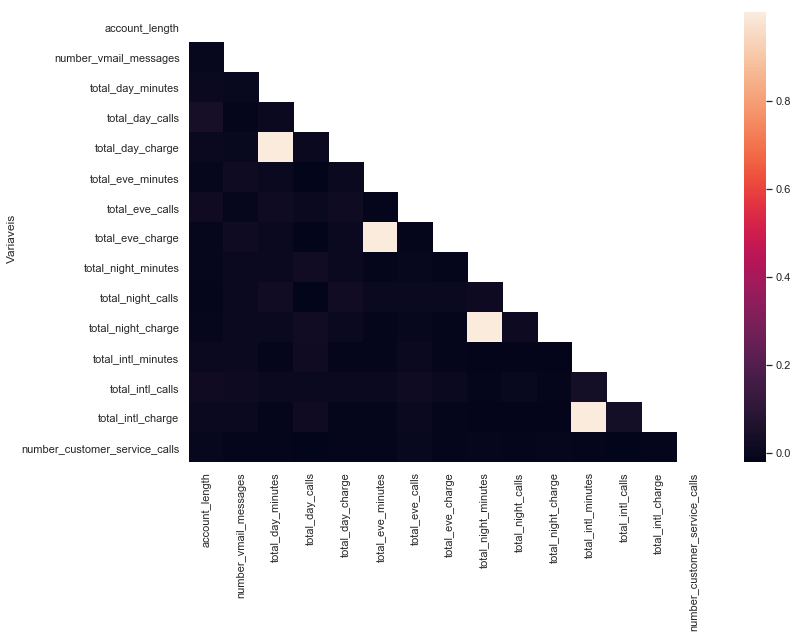

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)
sns.set_theme(style="white")
mask = np.triu(np.ones_like(Cordf, dtype=bool))
sns.heatmap(Cordf, mask = mask)

In [15]:
#Após analisar as variaveis numéricas, podemos visualizar as variaveis texto

DFtreino.select(listVarByType('string')).show()

+-----+-------------+------------------+---------------+-----+
|state|    area_code|international_plan|voice_mail_plan|churn|
+-----+-------------+------------------+---------------+-----+
|   KS|area_code_415|                no|            yes|   no|
|   OH|area_code_415|                no|            yes|   no|
|   NJ|area_code_415|                no|             no|   no|
|   OH|area_code_408|               yes|             no|   no|
|   OK|area_code_415|               yes|             no|   no|
|   AL|area_code_510|               yes|             no|   no|
|   MA|area_code_510|                no|            yes|   no|
|   MO|area_code_415|               yes|             no|   no|
|   LA|area_code_408|                no|             no|   no|
|   WV|area_code_415|               yes|            yes|   no|
|   IN|area_code_415|                no|             no|  yes|
|   RI|area_code_415|                no|             no|   no|
|   IA|area_code_408|                no|             no

In [16]:
#Verificando as novas variaveis alteradas, vale ressaltar que a variavel churn será a variavel dependente durante o desenvolvimento
#do modelo
DFtreino.select("international_plan","voice_mail_plan","churn").show()

+------------------+---------------+-----+
|international_plan|voice_mail_plan|churn|
+------------------+---------------+-----+
|                no|            yes|   no|
|                no|            yes|   no|
|                no|             no|   no|
|               yes|             no|   no|
|               yes|             no|   no|
|               yes|             no|   no|
|                no|            yes|   no|
|               yes|             no|   no|
|                no|             no|   no|
|               yes|            yes|   no|
|                no|             no|  yes|
|                no|             no|   no|
|                no|             no|   no|
|                no|             no|   no|
|                no|             no|   no|
|                no|             no|  yes|
|                no|            yes|   no|
|                no|             no|   no|
|                no|            yes|   no|
|                no|             no|   no|
+----------

In [17]:
# Após transformações verificando o número de NaN, None ou Nulls de todas as colunas do dataframe
from pyspark.sql.functions import col, isnan

DFtreino.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in DFtreino.columns ]).toPandas().head()

#É identificado a inexistencia de valores ausentes

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Análise Exploratória de dados

Vale ressaltar que durante esse processo de Análise Exploratória, onde muitos gráficos são gerados, para tentar simular o uso de uma base realmente de BigData, em nenhum momento transformarei a base inteira para dataframe Pandas para plotar os gráficos, sempre tentarei processar os dados intermediários em spark e os dados reduzidos serão transformados em data frames pandas para serem plotados.

In [18]:
#Checando se a varivel dependente para o modelo "Churn" está balanceada

DFtreino.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|   no| 2850|
|  yes|  483|
+-----+-----+



In [19]:
#Sumarizando os top 10 estados mais frequentes da base e criando uma tabela pandas

Top10States = DFtreino.select('state','churn').\
            groupBy("state",'churn').\
            count().\
            orderBy('count', ascending = False).\
            toPandas()
        

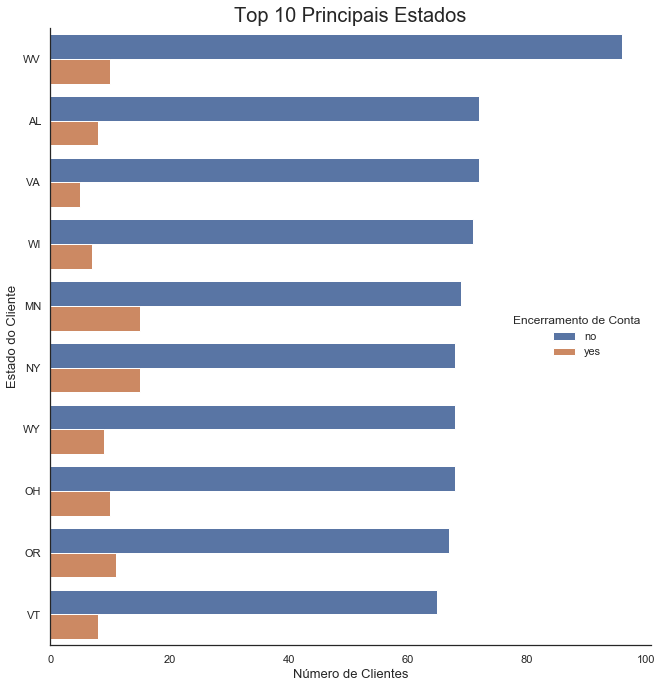

In [20]:
sns.set(font_scale=1.5)
sns.set_theme(style = 'white')
g = sns.catplot(
    data = Top10States, kind = 'bar',
    x='count',y = Top10States.loc[Top10States['state'].isin(Top10States.state.head(10).tolist()),'state'], hue ='churn',
    legend = False
)
g.fig.set_size_inches(10,10)
plt.xlabel('Número de Clientes', fontsize = 13)
plt.ylabel('Estado do Cliente', fontsize = 13)
plt.title('Top 10 Principais Estados', fontsize = 20)
plt.legend(title = 'Encerramento de Conta', loc = 'center right', edgecolor = 'white')

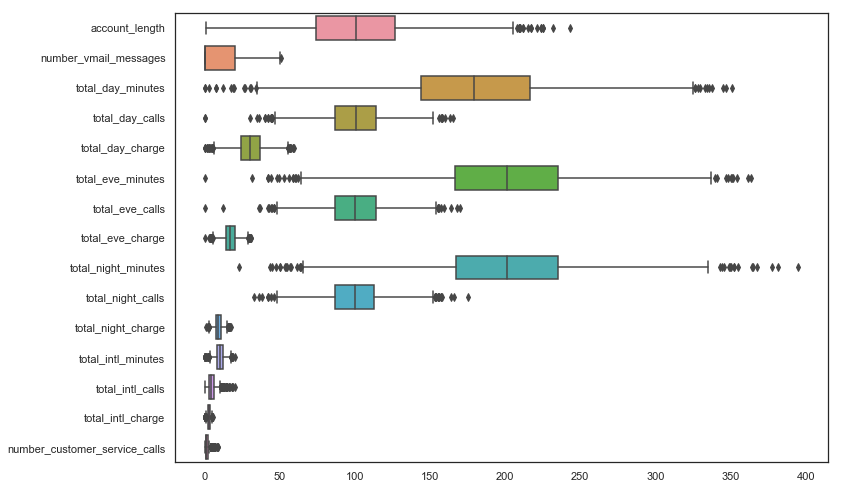

In [21]:
#Identificando a presença de outliers, outro presuposto para a regressão logistica
DFBoxPlot = DFtreino.select(listVarByType(['integer','double'])).toPandas()

sns.boxplot(data = DFBoxPlot, orient="h")

In [22]:
DoubleChurn = DFtreino.select(listVarByType(['double','integer'])+['churn']).groupby('churn').mean().toPandas()

In [23]:
DoubleChurn

,churn,avg(account_length),avg(number_vmail_messages),avg(total_day_minutes),avg(total_day_calls),avg(total_day_charge),avg(total_eve_minutes),avg(total_eve_calls),avg(total_eve_charge),avg(total_night_minutes),avg(total_night_calls),avg(total_night_charge),avg(total_intl_minutes),avg(total_intl_calls),avg(total_intl_charge),avg(number_customer_service_calls)
0,no,100.793684,8.604561,175.175754,100.283158,29.780421,199.043298,100.038596,16.918909,200.133193,100.058246,9.006074,10.158877,4.532982,2.743404,1.449825
1,yes,102.664596,5.115942,206.914079,101.335404,35.175921,212.410145,100.561077,18.054969,205.231677,100.399586,9.235528,10.700000,4.163561,2.889545,2.229814


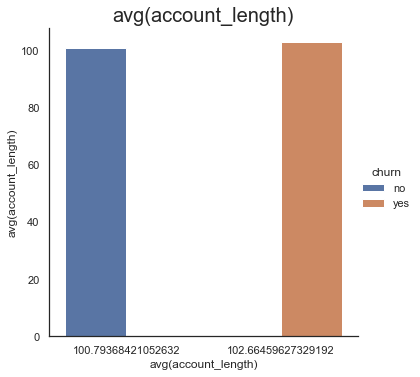

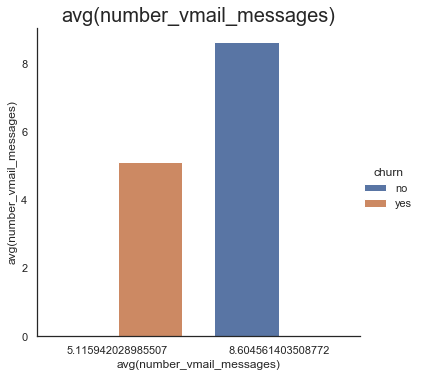

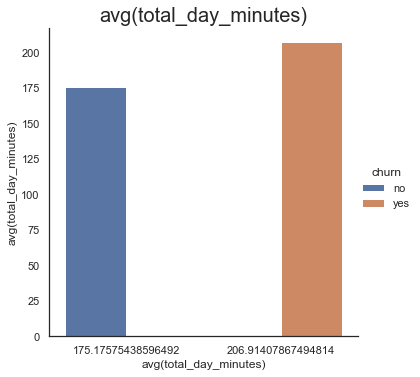

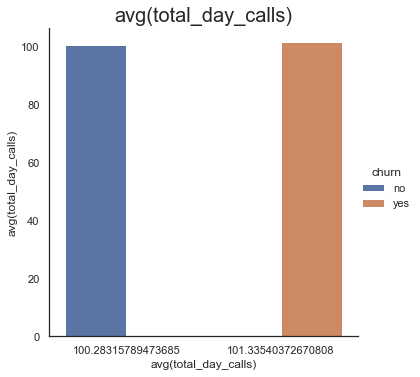

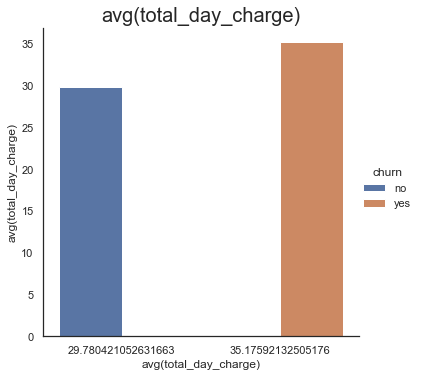

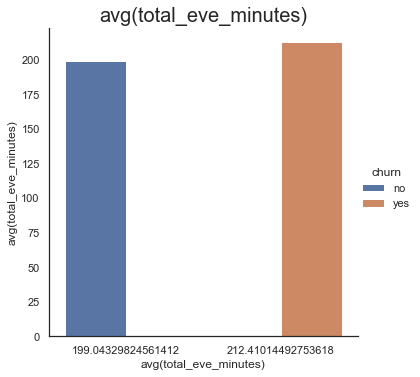

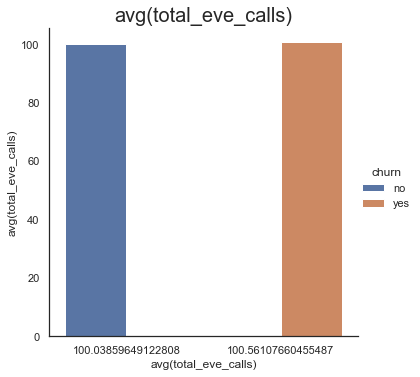

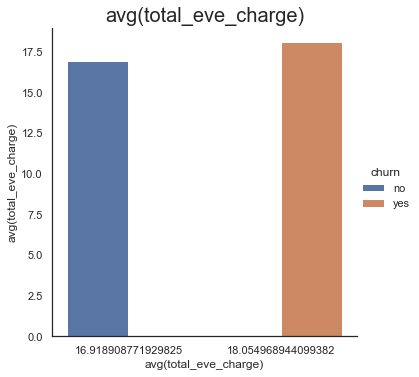

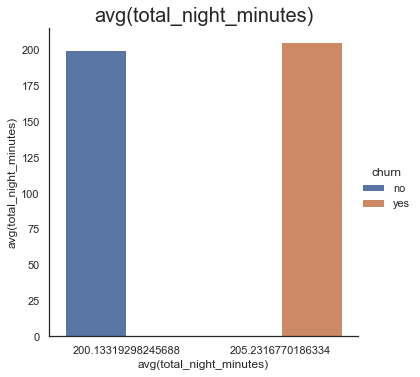

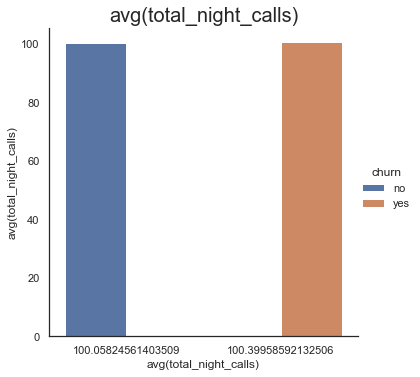

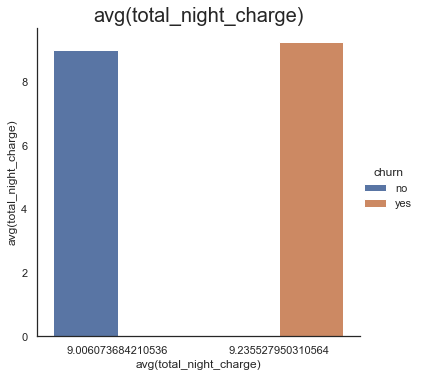

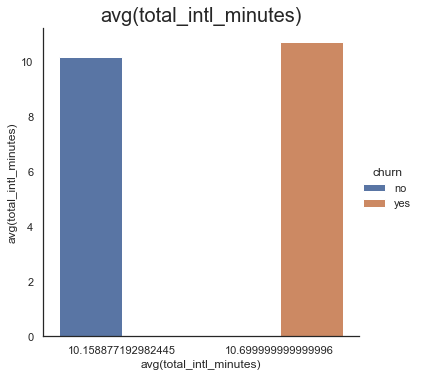

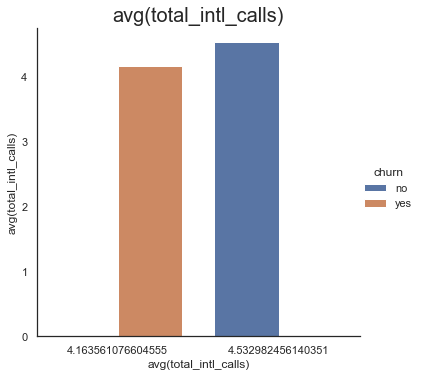

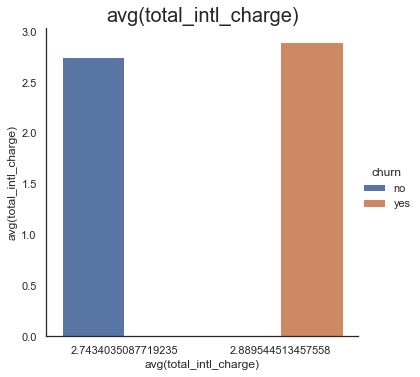

In [24]:
#Plotando a média de todas as variavies quantitaivas divididas em abandono ou não para entender a diferença média dos clientes
#Ideia inicial era comparar as distribuições de de cada variavel porém não foi encontrado jeito de realizar tal processo 
# sem transformar toda a base em data frame pandas

for col in DoubleChurn.columns[1:-1]:
    sns.catplot(
        data = DoubleChurn, kind = 'bar',
        x = col ,y = f'{col}', hue ='churn'
    )
    plt.title(f'{col}', fontsize = 20)


## Pré-Processamento de Dados

### Removendo Variáveis que apresentem multicolineariedade (correlação de pearson > 0.9)

In [25]:
def udf_rmMultiCol(df):
    df = df.drop("total_day_charge","total_eve_charge","total_night_charge","total_intl_charge", 'area_code')
    
    return df

DFtreino = udf_rmMultiCol(DFtreino)

### Aplicando Logaritmo aos Outliers

In [26]:
#Indentificando quantos zeros temos por coluna

import pyspark.sql.functions as F

DFtreino.select([F.count(F.when(DFtreino[c] == 0, c)).alias(c) for c in DFtreino.columns]).toPandas().transpose()

#Não iremos aplicar logaritmo em number_vmail e number_customer pois eles apresentam poucos outliers e muito valores 0 que 
#estão sendo excluidos

,0
state,0
account_length,0
international_plan,0
voice_mail_plan,0
number_vmail_messages,2411
total_day_minutes,2
total_day_calls,2
total_eve_minutes,1
total_eve_calls,1
total_night_minutes,0


In [27]:
#Retirando as colunas indesejadas do processo de transformação logaritimica
VariaveisNumericas = listVarByType(['integer','double'])

VariaveisNumericas.remove('number_customer_service_calls')
VariaveisNumericas.remove('number_vmail_messages')

In [28]:

def udf_Log(df):
    
    for col in df.select(VariaveisNumericas).columns:
        
        if df[df[f"{col}"].isin(0)] == None:
            df = df.withColumn(f"{col}", log(f"{col}"))
        else:
            df =df.where(f"{col}!=0")
            df = df.withColumn(f"{col}", log(f"{col}"))
    return df

DFtreino = udf_Log(DFtreino)

In [29]:
DFtreino.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
state,3312,None,None,AK,WY
account_length,3312,4.504182689367786,0.5605513720724045,0.0,5.493061443340548
international_plan,3312,None,None,no,yes
voice_mail_plan,3312,None,None,no,yes
number_vmail_messages,3312,8.121678743961352,13.707982267695696,0,51
total_day_minutes,3312,5.136712946420508,0.3658218436910406,0.9555114450274365,5.860216260498028
total_day_calls,3312,4.588495976496015,0.21083967064893466,3.4011973816621555,5.10594547390058
total_eve_minutes,3312,5.26807515269747,0.27928969214763716,3.4404180948154366,5.896329351992943
total_eve_calls,3312,4.5856027127767405,0.21174539996168362,2.4849066497880004,5.135798437050262


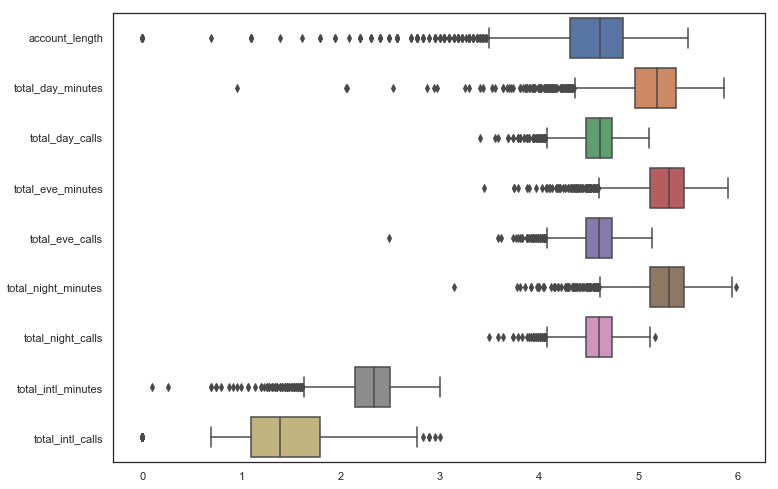

In [30]:
# Apartir desse segundo boxplot parece que a transformação só amenizou mas não resolveu a questão dos outliers
DFBoxPlot = DFtreino.select(VariaveisNumericas).toPandas()

sns.boxplot(data = DFBoxPlot, orient="h")

### Dummyficando algumas variavies

Nessa etapa, as variáveis que anteriormente era classicadas como Strings, serão transformadas em variáveis binárias, uma vez que os únicos valores textos apresentados nelas era "yes" ou "no"

In [31]:
#Entre as variáveis strings, indentificamos três colunas onde os valores possíveis são somente Yes ou No
#Para facilitar a interpretação e treino do modelo, é possivel transforma-las em variaveis dummmys (0 ou 1)

from pyspark.sql.functions import when

def udf_dummy(df):
    df = df.withColumn(colName = "international_plan",col = when(df.international_plan == "no",0)\
                                  .otherwise(1))\
               .withColumn(colName = 'voice_mail_plan', col =  when(df.voice_mail_plan == "no", 0)\
                           .otherwise(1))\
               .withColumn(colName = "churn", col = when(df.churn == "no",0)\
                          .otherwise(1))
    return df

DFtreino = udf_dummy(DFtreino)

Também será necessário criar uma dummy para cada estado presente na coluna state, e futuramente iremos dropar a coluna area code, uma vez que o vector não aceita variáveis Strings.

Para isso será usado duas funções StringIndexer e OneHotEncoding.

### String Indexer

Essa função converte textos para indices númericos, onde o valor mais frequente é o indice zero e o indice vai aumentando quanto menor a frequência de tal texto.

In [32]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer()\
                .setInputCol('state')\
                .setOutputCol('state_index')

stateIndex = stringIndexer.fit(DFtreino)
stateIndex = stateIndex.transform(DFtreino)

In [33]:
stateIndex.select('state_index').groupBy('state_index').count().orderBy('state_index').show()

+-----------+-----+
|state_index|count|
+-----------+-----+
|        0.0|  106|
|        1.0|   84|
|        2.0|   81|
|        3.0|   80|
|        4.0|   78|
|        5.0|   77|
|        6.0|   77|
|        7.0|   77|
|        8.0|   76|
|        9.0|   74|
|       10.0|   73|
|       11.0|   73|
|       12.0|   72|
|       13.0|   71|
|       14.0|   70|
|       15.0|   70|
|       16.0|   70|
|       17.0|   68|
|       18.0|   68|
|       19.0|   68|
+-----------+-----+
only showing top 20 rows



### OneHotEncoderEstimator
O OneHotEncoder cria um vetor esparço que transforma em dummy cada categoria da coluna state

In [34]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder()\
            .setInputCols(['state_index'])\
            .setOutputCols(['state_encoded'])

state_encoded = encoder.fit(stateIndex)
state_encoded = state_encoded.transform(stateIndex)

In [35]:
state_encoded.select('state_encoded').show()

+---------------+
|  state_encoded|
+---------------+
|(50,[17],[1.0])|
| (50,[5],[1.0])|
|(50,[20],[1.0])|
| (50,[5],[1.0])|
|(50,[35],[1.0])|
| (50,[3],[1.0])|
|(50,[27],[1.0])|
|(50,[30],[1.0])|
|(50,[47],[1.0])|
| (50,[0],[1.0])|
|(50,[14],[1.0])|
|(50,[25],[1.0])|
|(50,[49],[1.0])|
|(50,[18],[1.0])|
|(50,[49],[1.0])|
| (50,[2],[1.0])|
|(50,[10],[1.0])|
|(50,[16],[1.0])|
| (50,[8],[1.0])|
|(50,[12],[1.0])|
+---------------+
only showing top 20 rows



### Vector Assembler

A biblioteca mllib do pyspark, para processar seus modelos não utiliza de data frames, mas sim de vetores, e para transformas nossas variáveis em um vetor utilizavel pela biblioteca, basta utilizar a função VectoAssembler()

In [36]:
DFtreino.columns

['state',
 'account_length',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'number_customer_service_calls',
 'churn']

In [37]:
#Nesse ponto iremos selecionar todas as colunas exceto State, AreaCode e Churn, também passaremos para esse a recém criada
#state_encoded

assembler = VectorAssembler().setInputCols([
 'account_length',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'number_customer_service_calls',
 'state_encoded']).setOutputCol("vectorized_features")

assembled_df = assembler.transform(state_encoded)

In [38]:
assembled_df.select('state_index','state_encoded','vectorized_features').show()


+-----------+---------------+--------------------+
|state_index|  state_encoded| vectorized_features|
+-----------+---------------+--------------------+
|       17.0|(50,[17],[1.0])|(63,[0,2,3,4,5,6,...|
|        5.0| (50,[5],[1.0])|(63,[0,2,3,4,5,6,...|
|       20.0|(50,[20],[1.0])|(63,[0,4,5,6,7,8,...|
|        5.0| (50,[5],[1.0])|(63,[0,1,4,5,6,7,...|
|       35.0|(50,[35],[1.0])|(63,[0,1,4,5,6,7,...|
|        3.0| (50,[3],[1.0])|(63,[0,1,4,5,6,7,...|
|       27.0|(50,[27],[1.0])|(63,[0,2,3,4,5,6,...|
|       30.0|(50,[30],[1.0])|(63,[0,1,4,5,6,7,...|
|       47.0|(50,[47],[1.0])|(63,[0,4,5,6,7,8,...|
|        0.0| (50,[0],[1.0])|(63,[0,1,2,3,4,5,...|
|       14.0|(50,[14],[1.0])|(63,[0,4,5,6,7,8,...|
|       25.0|(50,[25],[1.0])|(63,[0,4,5,6,7,8,...|
|       49.0|(50,[49],[1.0])|(63,[0,4,5,6,7,8,...|
|       18.0|(50,[18],[1.0])|(63,[0,4,5,6,7,8,...|
|       49.0|(50,[49],[1.0])|(63,[0,4,5,6,7,8,...|
|        2.0| (50,[2],[1.0])|(63,[0,4,5,6,7,8,...|
|       10.0|(50,[10],[1.0])|(6

## Criando um pipeline para o modelo

Logo no inicio do código, é possível perceber que os dados já foram disponibilizados em 2 csvs um de treino e outro de teste,
para não ter que reescrever todo o código novamente podemos criar um pipeline com os processamentos realizados para aplicar também futuramente nos dados de teste.

In [49]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import SQLTransformer


pipeline = Pipeline()\
            .setStages([stringIndexer,encoder,assembler])

pipelineModel = pipeline.fit(DFtreino)

df_treino_final = pipelineModel.transform(DFtreino)
 
def PipelineModelo(df):
    
    df_final = udf_rmMultiCol(df)
    
    df_final = udf_Log(df_final)
    
    df_final = udf_dummy(df_final)

    df_final = pipelineModel.transform(df_final)
    
    return df_final

In [50]:
#Aplicando os mesmos processamentos nos dados de teste


df_teste_final = PipelineModelo(DFteste)

### Treinamento do modelo 

In [52]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = "vectorized_features", labelCol = 'churn', maxIter = 5)

lrModel = lr.fit(df_treino_final)

predictions_train = lrModel.transform(df_treino_final)


In [53]:
accuracy = predictions_train.filter(predictions_train.churn == predictions_train.prediction).count()/float(predictions_train.count())

print("Accuracy: ", accuracy)

Accuracy:  0.866243961352657


### Acurácia com dados de teste



In [54]:

predictions = lrModel.transform(df_teste_final)
accuracy_test = predictions.filter(predictions.churn == predictions.prediction).count()/float(predictions.count())
print("Accuracy: ", accuracy_test)

Accuracy:  0.8680722891566265


In [55]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valores Reais')
    plt.xlabel('Valores Previstos')

[[  50  173]
 [  46 1391]]


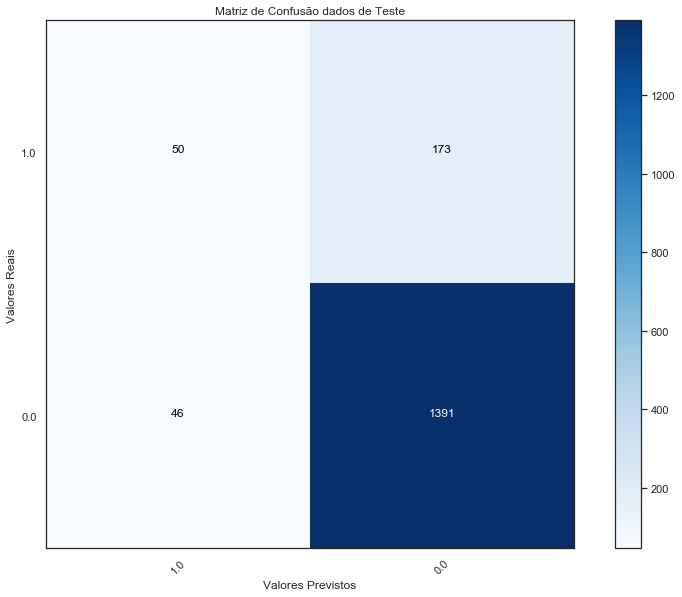

In [56]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("churn")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matriz de Confusão dados de Teste')
plt.show()